In [1]:
import pdfplumber
import fitz  # PyMuPDF
import base64
from IPython.display import display, Image as IPImage
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
import os 
from dotenv import load_dotenv
import nest_asyncio
from pathlib import Path
from openai import OpenAI
import contextlib
from langchain.chains.summarize import load_summarize_chain
from langchain_core.documents import Document
import logging
from langchain.text_splitter import RecursiveCharacterTextSplitter

current_directory = os.getcwd()
print("Current Directory:", current_directory)  # พิมพ์ที่อยู่ปัจจุบัน

# ปรับเส้นทางไปยังไฟล์ .env ในโฟลเดอร์ venv
env_path = Path(current_directory).parent.parent / 'venv' / '.env'
print("Env Path:", env_path)  # พิมพ์เส้นทางที่ไปยัง .env

load_dotenv(dotenv_path=env_path)


nest_asyncio.apply()

Current Directory: c:\Users\user\OneDrive\Desktop\Test_BOT_CSV\test\OCR
Env Path: c:\Users\user\OneDrive\Desktop\Test_BOT_CSV\venv\.env


In [2]:
# keys for the services we will use
OPENAI_API_KEY : str 
GROQ_API_KEY : str
LANGCHAIN_API_KEY : str
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
LANGCHAIN_API_KEY = os.getenv('LANGCHAIN_API_KEY')

In [3]:
# --------- อ่านข้อความและตารางจาก PDF ด้วย pdfplumber ---------
file_path = "./test_data/NIPS-2017-attention-is-all-you-need-Paper.pdf"
text_content = ""
tables_content = []

with pdfplumber.open(file_path) as pdf:
    for page_num, page in enumerate(pdf.pages, start=1):
        try:
            # อ่านข้อความ
            text = page.extract_text()
            if text:
                text_content += f"\n--- Page {page_num} ---\n{text}"
            
            # อ่านตาราง
            tables = page.extract_tables()
            if tables:
                for table in tables:
                    if table:  # ตรวจสอบว่าไม่ใช่ตารางเปล่า
                        tables_content.append(table)
        
        except Exception as e:
            print(f"❌ Error processing page {page_num}: {e}")
            
logging.getLogger("pdfminer").setLevel(logging.ERROR)  # ปิดคำเตือนที่บอก หน้านั้นใน PDF ไม่ได้กำหนด CropBox เอาไว้ → เลยใช้ MediaBox แทนเพื่อคำนวณขนาดและตำแหน่งในการตัดข้อมูล

CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, def

In [4]:
# --------- ดึงรูปภาพจาก PyMuPDF ---------
doc = fitz.open(file_path)
image_dir = "extracted_images"
os.makedirs(image_dir, exist_ok=True)

images_b64 = []

for page_index in range(len(doc)):
    page = doc.load_page(page_index)
    images = page.get_images(full=True)
    
    for img_index, img in enumerate(images):
        xref = img[0]
        base_image = doc.extract_image(xref)
        image_bytes = base_image["image"]
        image_ext = base_image["ext"]
        image_filename = f"page{page_index+1}_img{img_index+1}.{image_ext}"
        image_path = os.path.join(image_dir, image_filename)
        
        with open(image_path, "wb") as f:
            f.write(image_bytes)
        
        images_b64.append(base64.b64encode(image_bytes).decode("utf-8"))

print(f"พบรูปภาพจำนวน: {len(images_b64)}")

พบรูปภาพจำนวน: 3


In [5]:
# --------- การแสดงผลภาพ ---------
def display_base64_image(base64_code):
    image_data = base64.b64decode(base64_code)
    display(IPImage(data=image_data))

# change index look another image
# display_base64_image(images_b64[1])    

In [6]:
client = OpenAI(api_key=OPENAI_API_KEY)

image_b64 = images_b64[2]

prompt = """
กรุณาวิเคราะห์และอธิบายภาพด้านล่างอย่างละเอียด โดยเน้นการนำเสนอในเชิงวิชาการ เพื่อให้เหมาะสมสำหรับการนำไปใช้ในเอกสารวิจัยหรือเอกสารวิชาการทั่วไป

ข้อกำหนดการอธิบาย:
1. วิเคราะห์องค์ประกอบที่ปรากฏในภาพอย่างละเอียด ทั้งในเชิงโครงสร้าง เนื้อหา และความสัมพันธ์ของข้อมูล
2. หากภาพนั้นเป็นกราฟหรือแผนภูมิ ให้ระบุข้อมูลที่ปรากฏบนแกน X และแกน Y อย่างชัดเจน แต่หากไม่มีแกนดังกล่าว สามารถข้ามข้อนี้ได้
3. อธิบายลำดับความสัมพันธ์ของข้อมูลหรือองค์ประกอบต่าง ๆ โดยนำเสนอในรูปแบบลำดับขั้นตอน (Step-by-step) เริ่มจากองค์ประกอบหลักก่อน แล้วจึงอธิบายองค์ประกอบรองตามลำดับ
4. ต้องเขียนด้วยข้อความธรรมดาเท่านั้น ห้ามใช้รูปแบบ Markdown เช่น การทำตัวหนา ตัวเอียง หรือการเน้นข้อความด้วยสัญลักษณ์พิเศษ เช่น ** ## * _
5. เนื้อหาต้องจัดเรียงให้อ่านง่าย ชัดเจน เป็นระบบ และมีความต่อเนื่องของตรรกะ
6. ใช้ภาษาทางวิชาการที่สุภาพ ถูกต้อง และสมบูรณ์ เหมาะสมสำหรับการนำไปใช้อ้างอิงในงานวิจัยหรือเอกสารวิชาการในทุกสาขา

หมายเหตุ: คำอธิบายควรมีความละเอียด ครอบคลุม และคำนึงถึงความสมบูรณ์ของเนื้อหาเป็นสำคัญ
"""

response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": prompt
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{image_b64}"
                    }
                }
            ]
        }
    ],
    temperature=0
)

# แสดงผลลัพธ์
print(response.choices[0].message.content)

ภาพที่นำเสนอเป็นแผนภาพที่แสดงถึงกระบวนการทำงานของโมเดลการเรียนรู้เชิงลึก โดยเฉพาะในบริบทของการประมวลผลข้อมูลที่เกี่ยวข้องกับการทำ Attention Mechanism ซึ่งเป็นส่วนสำคัญในโมเดลเช่น Transformer

1. องค์ประกอบหลักในภาพประกอบด้วย:
   - MatMul (Matrix Multiplication): มีการปรากฏอยู่ในหลายจุดในภาพ โดยทำหน้าที่ในการคูณเมทริกซ์ ซึ่งเป็นขั้นตอนสำคัญในการคำนวณความสัมพันธ์ระหว่างข้อมูล
   - SoftMax: ทำหน้าที่ในการแปลงค่าที่ได้จากการคูณเมทริกซ์ให้เป็นค่าความน่าจะเป็น โดยการปรับให้ผลลัพธ์มีค่าระหว่าง 0 ถึง 1
   - Mask (optional): เป็นขั้นตอนที่ใช้ในการป้องกันไม่ให้โมเดลเข้าถึงข้อมูลที่ไม่ต้องการในระหว่างการประมวลผล
   - Scale: ใช้ในการปรับขนาดค่าที่ได้จากการคูณเมทริกซ์ เพื่อให้การคำนวณมีความเสถียรและมีประสิทธิภาพมากขึ้น
   - Q, K, V: แทนข้อมูลที่ใช้ในการคำนวณ Attention โดย Q (Query), K (Key), และ V (Value) เป็นองค์ประกอบที่สำคัญในการสร้างความสัมพันธ์ระหว่างข้อมูล

2. ในแผนภาพนี้ไม่มีแกน X และ Y เนื่องจากเป็นแผนภาพที่แสดงกระบวนการทำงาน ไม่ใช่กราฟหรือแผนภูมิที่มีการวัดค่าตามแกน

3. ลำดับความสัมพันธ์ขอ

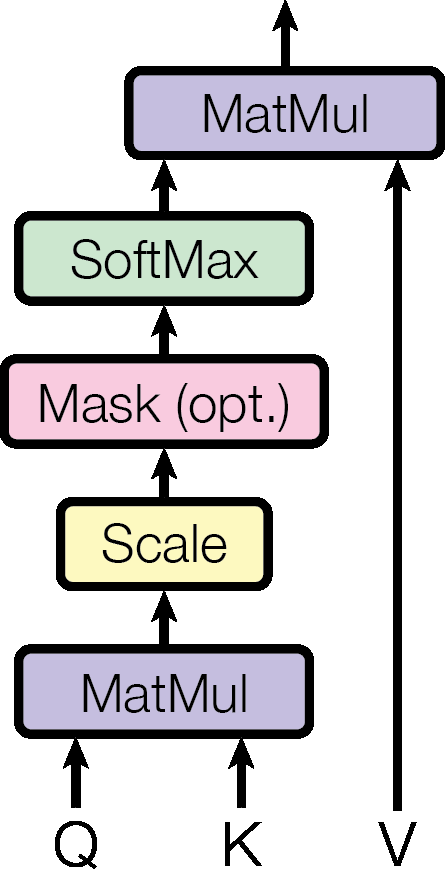

In [7]:
display_base64_image(images_b64[2])

Read text

In [7]:
llm = ChatOpenAI(model="gpt-4", temperature=0.5)
summarize_chain = load_summarize_chain(llm, chain_type="stuff")
text_documents = [Document(page_content=text_content)]


In [13]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2000,
    chunk_overlap=200,  # ให้มีบริบทซ้อนเล็กน้อย
)

In [14]:
documents = text_splitter.create_documents([text_content])


In [15]:
# สรุปแต่ละ chunk ทีละตัว
text_summaries = []
for i, doc in enumerate(documents):
    print(f"🔍 Summarizing chunk {i+1}/{len(documents)}...")
    summary = summarize_chain.invoke({"input_documents": [doc]})
    text_summaries.append(summary["output_text"])

🔍 Summarizing chunk 1/17...
🔍 Summarizing chunk 2/17...
🔍 Summarizing chunk 3/17...
🔍 Summarizing chunk 4/17...
🔍 Summarizing chunk 5/17...
🔍 Summarizing chunk 6/17...
🔍 Summarizing chunk 7/17...
🔍 Summarizing chunk 8/17...
🔍 Summarizing chunk 9/17...
🔍 Summarizing chunk 10/17...
🔍 Summarizing chunk 11/17...
🔍 Summarizing chunk 12/17...
🔍 Summarizing chunk 13/17...
🔍 Summarizing chunk 14/17...
🔍 Summarizing chunk 15/17...
🔍 Summarizing chunk 16/17...
🔍 Summarizing chunk 17/17...


In [16]:
# รวมทั้งหมดเป็นข้อความเดียว
full_summary = "\n\n".join(text_summaries)

In [17]:
# แสดงผล
print("\n✅ Full Summary:\n", full_summary)


✅ Full Summary:
 Google Brain researchers propose a new network architecture called the Transformer, which is based solely on attention mechanisms and does not include recurrent or convolutional neural networks. Experiments on two machine translation tasks show these models to be superior in quality, more parallelizable, and require less time to train. The model achieved a new single-model state-of-the-art BLEU score of 41.0 after training for 3.5 days on eight GPUs, improving over the existing best results.

Ashish and Illia designed and implemented the first Transformer models, with Noam proposing key features such as scaled dot-product attention, multi-head attention, and the parameter-free position representation. Niki and Llion were responsible for designing, implementing, and evaluating numerous model variants, while Lukasz and Aidan worked on developing the tensor2tensor codebase. The work was performed at Google Brain and Google Research. The Transformer model is a new archite

Read Table

In [21]:
# แปลงตารางเป็นข้อความ
table_texts = []
for table in tables_content:
    # แปลงแต่ละแถวของตารางเป็นข้อความ
    table_text = "\n".join(["\t".join(row) for row in table if row])  # ใช้ tab คั่นระหว่างคอลัมน์
    table_texts.append(table_text)


In [24]:
# สร้าง Document สำหรับตาราง
table_documents = [Document(page_content=table_text) for table_text in table_texts]

In [25]:
# สรุปตาราง
print("🔍 Summarizing tables...")
table_summaries = []
for doc in table_documents:
    summary = summarize_chain.invoke({"input_documents": [doc]})
    table_summaries.append(summary["output_text"])


🔍 Summarizing tables...


In [26]:
# สรุปตาราง
print("🔍 Summarizing tables...")
table_summaries = []
for doc in table_documents:
    summary = summarize_chain.invoke({"input_documents": [doc]})
    table_summaries.append(summary["output_text"])

🔍 Summarizing tables...


In [27]:
# รวมผลสรุป
full_table_summary = "\n\n".join(table_summaries)

In [28]:
# แสดงผล
print("\n✅ Full Table Summary:\n", full_table_summary)


✅ Full Table Summary:
 The text appears to be a list of parameters or settings for a machine learning model or algorithm, possibly related to neural networks or deep learning. It includes values for model layers, dimensionalities, dropout rates, learning rates, and training steps. There's also a mention of using positional embedding instead of sinusoids, which suggests a specific approach to handling sequential data.
